**Dhava Gautama**
<br>Time series suhu harian Jakarta. Data yang digunakan adalah data suhu harian Jakarta tahun 1980 sampai 2020 yang di ekstrak dari data **Temperature History of 1000 cities 1980 to 2020** yang bersumber dari **Kaggle** (https://www.kaggle.com/datasets/hansukyang/temperature-history-of-1000-cities-1980-to-2020)

In [1]:
# Import Library
import pandas as pd
import re

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load Data
df = pd.read_csv("/content/daily_jakarta_1980_2020.csv")
df.head()

,datetime,temp
0,1/1/1980,26.25
1,1/2/1980,26.12
2,1/3/1980,26.08
3,1/4/1980,26.32
4,1/5/1980,26.53


In [3]:
# Check data kosong
df.isnull().sum()

datetime    0
temp        0
dtype: int64

In [4]:
# Konversi data datetime
df['datetime']=pd.to_datetime(df['datetime'])
df['datetime'].head()

0   1980-01-01
1   1980-01-02
2   1980-01-03
3   1980-01-04
4   1980-01-05
Name: datetime, dtype: datetime64[ns]

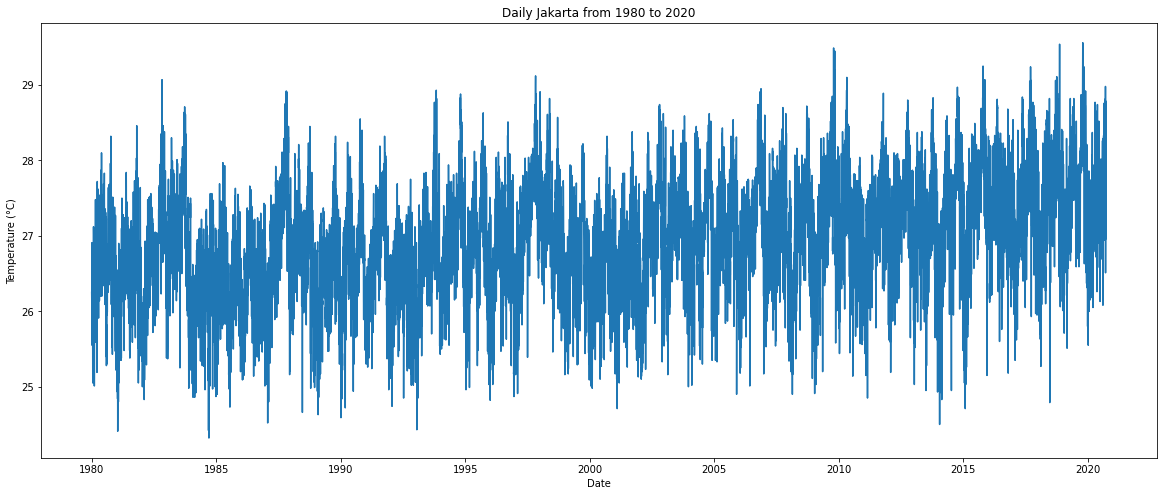

In [5]:
# Plot Timeseries Daily Jakarta from 1980 to 2020
jakarta = df[['datetime','temp']].copy()
jakarta.set_index('datetime', inplace= True)
plt.figure(figsize=(20,8))
plt.plot(jakarta)
plt.title('Daily Jakarta from 1980 to 2020')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

In [6]:
# Mengdapatkan value
date = df['datetime'].values
temp = df['temp'].values

In [7]:
# Split dataset (20% dari dataset sebagai validation)
x_train, x_test, y_train, y_test = train_test_split(temp, date, test_size = 0.2, random_state = 0 , shuffle=False)
print('Jumlah sample training:',len(x_train))
print('Jumlah sample test:',len(x_test))

Jumlah sample training: 11907
Jumlah sample test: 2977


In [13]:
# Normalisasi data dengan MinMaxScaler
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(x_train.reshape(-1, 1))
x_train_scaled = min_max_scaler.transform(x_train.reshape(-1, 1))
x_test_scaled = min_max_scaler.transform(x_test.reshape(-1, 1))

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [30]:
# Gunakan model LSTM

data_x_train = windowed_dataset(x_train_scaled, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test_scaled, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 500),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 32)          192       
                                                                 
 lstm_16 (LSTM)              (None, None, 64)          24832     
                                                                 
 lstm_17 (LSTM)              (None, None, 64)          33024     
                                                                 
 dense_24 (Dense)            (None, None, 30)          1950      
                                                                 
 dense_25 (Dense)            (None, None, 10)          310       
                                                                 
 dense_26 (Dense)            (None, None, 1)           11        
                                                                 
 lambda_1 (Lambda)           (None, None, 1)          

In [25]:
# Callback dengan treshold mae
threshold_mae = (df['temp'].max() - df['temp'].min()) * 7.5/100
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< threshold_mae):
      self.model.stop_training = True
      print("\nMAE of the model < 7.5% of data scale")
callbacks = myCallback()

In [31]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train ,epochs=500, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/500
119/119 [==============================] - 12s 64ms/step - loss: 2.9393 - mae: 3.4042 - val_loss: 1.5472 - val_mae: 2.0024
Epoch 2/500
119/119 [==============================] - 7s 53ms/step - loss: 1.1525 - mae: 1.5898 - val_loss: 1.4922 - val_mae: 1.9474
Epoch 3/500
119/119 [==============================] - 7s 53ms/step - loss: 1.0660 - mae: 1.5004 - val_loss: 1.3979 - val_mae: 1.8507
Epoch 4/500
119/119 [==============================] - 7s 52ms/step - loss: 0.9819 - mae: 1.4133 - val_loss: 1.3070 - val_mae: 1.7572
Epoch 5/500
119/119 [==============================] - 7s 53ms/step - loss: 0.8918 - mae: 1.3193 - val_loss: 1.1915 - val_mae: 1.6366
Epoch 6/500
119/119 [==============================] - 7s 53ms/step - loss: 0.7874 - mae: 1.2061 - val_loss: 1.0945 - val_mae: 1.5299
Epoch 7/500
119/119 [==============================] - 7s 53ms/step - loss: 0.6625 - mae: 1.0597 - val_loss: 0.9450 - val_mae: 1.3636
Epoch 8/500
119/119 [==============================] - 7s 54m

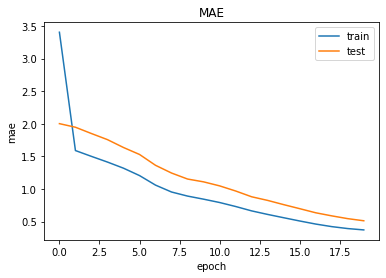

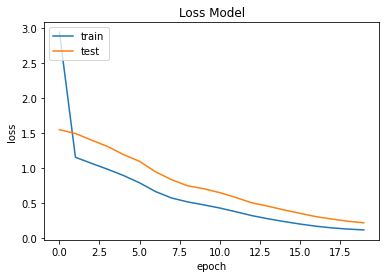

In [32]:
# Plot MAE
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()